### Initial setup

In [2]:
%load_ext autoreload
%autoreload 1

import tensorflow as tf
import netvlad_tf.nets as nets

import itertools
import scipy
import scipy.spatial

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D


%matplotlib inline

import os
from os import listdir, symlink
from os.path import join, isfile, basename, abspath
from pathlib import Path

import numpy as np

from tqdm.auto import tqdm

from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

%aimport code_helpers_public_pr_curve, code_helpers_public, correspondence_event_camera_frame_camera, read_gps
from code_helpers_public_pr_curve import getPAt100R, getPR, getPRCurve, getPRCurveWrapper, getRAt99P, get_recall_helper
from code_helpers_public import compare_images, get_timestamps, get_timestamp_matches, get_image_sets_on_demand, get_vlad_features
from read_gps import get_gps
from correspondence_event_camera_frame_camera import traverse_to_name, name_to_consumervideo, video_beginning

tqdm.get_lock().locks = []

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
dataset_folder = '/media/sandisk/event_dataset/reconstructed_videos_from_events/'
num_events_per_pixel_list = [0.1, 0.3, 0.6, 0.8]
window_duration_list = [44, 66, 88, 120, 140]

query_traverse = 'dvs_vpr_2020-04-21-17-03-03'
reference_traverse = 'dvs_vpr_2020-04-22-17-24-21'

comparison_id = query_traverse + '_' + reference_traverse

frames_subfolder = 'frames'
event_subfolders = ['N_' + str(num_events_per_pixel) for num_events_per_pixel in num_events_per_pixel_list]
event_subfolder_preview = 'N_0.1'
fixed_event_subfolders = ['t_' + str(window_duration) for window_duration in window_duration_list]
fixed_event_subfolder_preview = 't_120'

all_subfolders = [frames_subfolder] + event_subfolders + fixed_event_subfolders


def get_image_paths(folder1, folder2):
    return sorted([join(folder1, f) for f in listdir(folder1) if f.endswith('.png')]), \
           sorted([join(folder2, f) for f in listdir(folder2) if f.endswith('.png')])


overall_data_dir = join(dataset_folder, 'overall_data', comparison_id)
path_to_plots = overall_data_dir + '/plots'

if not os.path.isdir(overall_data_dir):
    os.makedirs(overall_data_dir)
    os.makedirs(overall_data_dir + '/plots')

image_paths_combined1 = {}
image_paths_combined2 = {}

for subfolder in all_subfolders:
    image_paths_combined1[subfolder], image_paths_combined2[subfolder] = get_image_paths(join(dataset_folder, subfolder, query_traverse), join(dataset_folder, subfolder, reference_traverse))
    if not os.path.isdir(join(overall_data_dir, subfolder)):
        os.makedirs(join(overall_data_dir, subfolder))

In [7]:
timestamps_combined1 = {}; timestamps_combined2 = {}

for subfolder in all_subfolders:
    if subfolder == 'frames':
        timestamps_combined1[subfolder] = np.array([float(os.path.splitext(basename(f))[0]) for f in image_paths_combined1[subfolder]])
        timestamps_combined2[subfolder] = np.array([float(os.path.splitext(basename(f))[0]) for f in image_paths_combined2[subfolder]])
    else:
        timestamps_combined1[subfolder], timestamps_combined2[subfolder] = get_timestamps(join(dataset_folder, subfolder, query_traverse), join(dataset_folder, subfolder, reference_traverse))

In [8]:
vid_path_1 = join(dataset_folder, 'camera_vids', name_to_consumervideo[traverse_to_name[query_traverse]])
vid_path_2 = join(dataset_folder, 'camera_vids', name_to_consumervideo[traverse_to_name[reference_traverse]])

In [11]:
x1 = get_gps(vid_path_1 + '.nmea')
x2 = get_gps(vid_path_2 + '.nmea')

match_x1_to_x2 = []
for idx1, (latlon, t) in enumerate(zip(x1[:, 0:2], x1[:, 2])):
    if len(match_x1_to_x2) < 6:
        min_idx2 = 0
        max_idx2 = int(0.25 * len(x2))
    elif idx1 > 0.5 * len(x1):
        min_idx2 = match_x1_to_x2[-5]
        max_idx2 = len(x2)
    else:
        min_idx2 = match_x1_to_x2[-5]
        max_idx2 = int(0.75 * len(x2))
    best_match = (np.linalg.norm(x2[min_idx2:max_idx2, 0:2] - latlon, axis=1)).argmin() + min_idx2
    # print('%d %.4f' % (idx1, np.linalg.norm(x2[best_match, 0:2] - latlon)))
    match_x1_to_x2.append(best_match)
match_x1_to_x2 = np.array(match_x1_to_x2)

t_raw1 = x1[:, 2]
t_raw2 = x2[match_x1_to_x2, 2]
timestamps_gps1 = np.array([t + video_beginning[traverse_to_name[query_traverse]] for t in t_raw1])
timestamps_gps2 = np.array([t + video_beginning[traverse_to_name[reference_traverse]] for t in t_raw2])

images_all_combined_set1 = {}; images_all_combined_set2 = {}
matches_fixedlength_combined1 = {}; matches_fixedlength_combined2 = {}

for subfolder in all_subfolders:
    matches_fixedlength_combined1[subfolder] = get_timestamp_matches(timestamps_combined1[subfolder], timestamps_gps1)
    matches_fixedlength_combined2[subfolder] = get_timestamp_matches(timestamps_combined2[subfolder], timestamps_gps2)
    images_all_combined_set1[subfolder], images_all_combined_set2[subfolder] = \
        get_image_sets_on_demand(image_paths_combined1[subfolder], image_paths_combined2[subfolder], 
                                 matches_fixedlength_combined1[subfolder], matches_fixedlength_combined2[subfolder])

### Preview annotations

In [17]:
fixed_compare_folder = event_subfolder_preview

image_num1_fixed_widget = widgets.IntSlider(min = 0, max = len(images_all_combined_set1[fixed_compare_folder]) - 1, step = 1, value = 0, continuous_update = False)
image_num2_fixed_widget = widgets.IntSlider(min = 0, max = len(images_all_combined_set2[fixed_compare_folder]) - 1, step = 1, value = 0, continuous_update = False)
image_num2_fixed_widget.layout = widgets.Layout(visibility = 'hidden')
widgets.jslink((image_num1_fixed_widget, 'value'), (image_num2_fixed_widget, 'value'))

my_widgets_fixed_linked = interactive(compare_images, 
                                      image_paths1=fixed(images_all_combined_set1[fixed_compare_folder].get_path_list()), image_paths2=fixed(images_all_combined_set2[fixed_compare_folder].get_path_list()), 
                                      image_num1=image_num1_fixed_widget, image_num2=image_num2_fixed_widget)
my_widgets_fixed_linked

interactive(children=(IntSlider(value=0, continuous_update=False, description='image_num1', max=577), IntSlide…

### Feature extraction

In [18]:
tf.compat.v1.disable_eager_execution(); tf.compat.v1.reset_default_graph()
image_batch = tf.compat.v1.placeholder(dtype=tf.float32, shape=[None, None, None, 3])

net_out = nets.vgg16NetvladPca(image_batch)
saver = tf.compat.v1.train.Saver()

gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.5)
config = tf.compat.v1.ConfigProto(inter_op_parallelism_threads=1, intra_op_parallelism_threads=1, gpu_options=gpu_options)
config.gpu_options.allow_growth = True
config.log_device_placement = True
sess = tf.compat.v1.Session(config=config)

saver.restore(sess, nets.defaultCheckpoint())

print('Done')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.MaxPooling2D instead.
Instructions for updating:
Use keras.layers.Flatten instead.
Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device

INFO:tensorflow:Restoring parameters from /home/tobias/robot/netvlad_tf_open/checkpoints/vd16_pitts30k_conv5_3_vlad_preL2_intra_white
Done


In [22]:
features_all_combined1 = {}; features_all_combined2 = {}; dist_matrix_all_combined = {}

with tqdm(total = 2 * len(all_subfolders), position = 0, leave = False) as pbar:
    for subfolder in all_subfolders:
        features_all_combined1[subfolder]   = get_vlad_features(sess, net_out, image_batch, images_all_combined_set1[subfolder], join(overall_data_dir, subfolder, 'netvlad_features_all_set1' + '.npy')); pbar.update(1)
        features_all_combined2[subfolder]   = get_vlad_features(sess, net_out, image_batch, images_all_combined_set2[subfolder], join(overall_data_dir, subfolder, 'netvlad_features_all_set2' + '.npy')); pbar.update(1)
        dist_matrix_all_combined[subfolder] = scipy.spatial.distance.cdist(features_all_combined1[subfolder], features_all_combined2[subfolder], 'cosine').T

dist_matrix_shape = dist_matrix_all_combined[frames_subfolder].shape
assert dist_matrix_shape == (len(images_all_combined_set1['frames']), len(images_all_combined_set2['frames']))

### Ensemble stuff

In [23]:
max_dist_plot = 20
plot_threshold_fps = 6

In [24]:
ensemble_init_kind_widget = widgets.Dropdown(options=['frames', 'zeros'], value='frames', description='Ensemble init kind:')
ensemble_init_kind_widget

Dropdown(description='Ensemble init kind:', options=('frames', 'zeros'), value='frames')

In [27]:
ensemble_init_kind = ensemble_init_kind_widget.value

matchIndsCombined = []

if ensemble_init_kind == 'zeros':
    print('Init with zeros')
    ensemble_init = np.zeros(dist_matrix_shape)
    init_len = 0
elif ensemble_init_kind == 'frames':
    print('Include frames in ensemble')
    ensemble_init = dist_matrix_all_combined[frames_subfolder]
    init_len = 1
    matchIndsCombined.append(np.argmin(dist_matrix_all_combined[frames_subfolder], axis=0))
else:
    raise ValueError('Wrong init type')

dist_matrix_ensemble = ensemble_init.copy()

for event_subfolder in event_subfolders:
    dist_matrix_ensemble += dist_matrix_all_combined[event_subfolder]

for fixed_event_subfolder in fixed_event_subfolders:
    dist_matrix_ensemble += dist_matrix_all_combined[fixed_event_subfolder]

dist_matrix_ensemble = dist_matrix_ensemble / (len(event_subfolders) + len(fixed_event_subfolders) + init_len)

Init with zeros


In [29]:
with tqdm(total=1 + len(all_subfolders), position=0, leave=False) as pbar:
    recalls_combined = {}; tps_combined = {}; best_matches_combined = {}
    recalls_best_individual = None; tps_best_individual=None; best_matches_individual=None

    recall_ensemble, tps_ensemble, best_matches_ensemble = get_recall_helper(dist_matrix_ensemble)
    pbar.update(1)

    for subfolder in all_subfolders:
        recalls_combined[subfolder], tps_combined[subfolder], best_matches_combined[subfolder] = get_recall_helper(dist_matrix_all_combined[subfolder])
        pbar.update(1)

        if subfolder!='frames' and (recalls_best_individual is None or recalls_combined[subfolder][plot_threshold_fps] > recalls_best_individual[plot_threshold_fps]):
            recalls_best_individual, tps_best_individual, best_matches_individual = recalls_combined[subfolder], tps_combined[subfolder], best_matches_combined[subfolder]
            best_individual_name = subfolder

print('\n')
print('Frame:                        %.3f' % recalls_combined['frames'][plot_threshold_fps])
print('Best individual method        %.3f (%s)' % (recalls_best_individual[plot_threshold_fps], best_individual_name))
print('Ensemble:                     %.3f' % recall_ensemble[plot_threshold_fps])

                                             

Frame:                        0.836
Best individual method        0.832 (t_120)
Ensemble:                     0.888


### Plotting

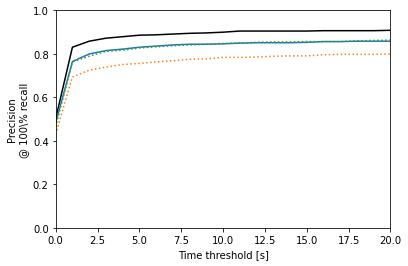

In [30]:
plt.plot(recall_ensemble, '-', label='Ensemble method', color='black')
plt.plot(recalls_combined[frames_subfolder], '-', label='Frame-based')

style=itertools.cycle(["-", "--", "-.", ":"])

for event_subfolder in event_subfolders:
    plt.plot(recalls_combined[event_subfolder], ":")  # , label='Event-based ' + event_subfolder

for fixed_event_subfolder in fixed_event_subfolders:
    plt.plot(recalls_combined[fixed_event_subfolder], ":")  # , label='Event-based ' + fixed_event_subfolder

custom_line = Line2D([], [], color='brown', ls=':', label='Individual models')
handles, labels = plt.gca().get_legend_handles_labels()
handles.append(custom_line)
labels.append('Individual models')

plt.xlabel("Time threshold [s]")
plt.ylabel("Precision\n@ 100\% recall")
plt.xlim(0, max_dist_plot)
plt.ylim(0, 1.0)

plt.savefig(join(path_to_plots, 'recall_curve_' + ensemble_init_kind + '.pdf'), bbox_inches='tight')
plt.savefig(join(path_to_plots, 'recall_curve_' + ensemble_init_kind + '.pgf'), bbox_inches='tight')

plt.show()
plt.close()

In [34]:
pr_ensemble = getPRCurveWrapper(dist_matrix_ensemble, plot_threshold_fps)
pr_frames = getPRCurveWrapper(dist_matrix_all_combined['frames'], plot_threshold_fps)

pr_event_combined = {}
for subfolder in all_subfolders:
    pr_event_combined[subfolder] = getPRCurveWrapper(dist_matrix_all_combined[subfolder], plot_threshold_fps)

In [35]:
print('PAt100R ensemble: %.3f' % getPAt100R(np.abs(np.argmin(dist_matrix_ensemble, axis=0)-np.arange(len(dist_matrix_ensemble))), plot_threshold_fps)[-1])

PAt100R ensemble: 0.886


In [36]:
print('getRAt99P ensemble: %.3f' % getRAt99P(pr_ensemble))

getRAt99P ensemble: 0.437


In [37]:
print('PAt100R best    : %.3f' % getPAt100R(np.abs(np.argmin(dist_matrix_all_combined[best_individual_name], axis=0)-np.arange(len(dist_matrix_ensemble))), plot_threshold_fps)[-1])

PAt100R best    : 0.827


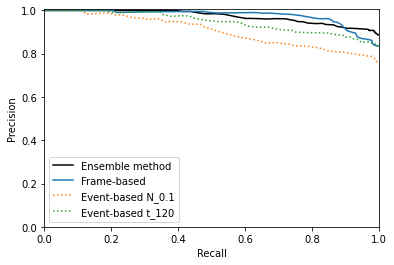

In [38]:
plt.plot(pr_ensemble[:, 1], pr_ensemble[:, 0], '-', label='Ensemble method', color='black')
plt.plot(pr_event_combined[frames_subfolder][:, 1], pr_event_combined[frames_subfolder][:, 0], '-', label='Frame-based')

style=itertools.cycle(["-", "--", "-.", ":"])

for event_subfolder in event_subfolders:
    plt.plot(pr_event_combined[event_subfolder][:, 1], pr_event_combined[event_subfolder][:, 0], ":", label='Event-based ' + event_subfolder)

for fixed_event_subfolder in fixed_event_subfolders:
    plt.plot(pr_event_combined[fixed_event_subfolder][:, 1], pr_event_combined[fixed_event_subfolder][:, 0], ":", label='Event-based ' + fixed_event_subfolder)

custom_line = Line2D([], [], color='brown', ls=':', label='Individual models')
handles, labels = plt.gca().get_legend_handles_labels()
handles.append(custom_line)
labels.append('Individual models')

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.xlim(0, 1.0)
plt.ylim(0.0, 1.005)
plt.legend()

plt.savefig(join(path_to_plots, 'pr_curve_' + ensemble_init_kind + '.pdf'), bbox_inches='tight')

plt.show()
plt.close()

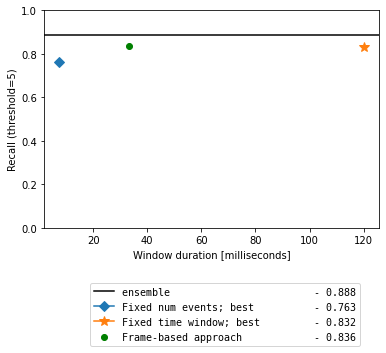

In [39]:
avg_window_durations = []
num_events_per_pixels = []
xs_events, ys_events = [], []
xs_events_window, ys_events_window = [], []
xs_fixed_events, ys_fixed_events = [], []
rat99ps = []

perf_frames = recalls_combined[frames_subfolder][plot_threshold_fps]
perf_ensemble = recall_ensemble[plot_threshold_fps]

for event_subfolder in event_subfolders:
    perf = recalls_combined[event_subfolder][plot_threshold_fps]
    num_events_per_pixel = float(event_subfolder[event_subfolder.find('_')+1:])
    num_events_per_pixels.append(num_events_per_pixel)
    # TODO: Remove unique stuff which is/was for super low pixels per event
    avg_window_duration = (np.median(np.diff(np.unique(timestamps_combined1[event_subfolder]))) + np.median(np.diff(np.unique(timestamps_combined2[event_subfolder])))) / 2.0 * 1000.0
    avg_window_durations.append(avg_window_duration)
    xs_events.append(num_events_per_pixel); xs_events_window.append(avg_window_duration)
    ys_events.append(perf); ys_events_window.append(perf)
    rat99ps.append(getRAt99P(pr_event_combined[event_subfolder]))

for fixed_event_subfolder in fixed_event_subfolders:
    perf = recalls_combined[fixed_event_subfolder][plot_threshold_fps]
    window_duration = float(fixed_event_subfolder[fixed_event_subfolder.find('_')+1:])
    xs_fixed_events.append(window_duration)
    ys_fixed_events.append(perf)
    rat99ps.append(getRAt99P(pr_event_combined[fixed_event_subfolder]))

plt.ylabel("Recall (threshold=%d)" % (plot_threshold_fps-1))

plt.ylim(0.0, 1.0)

plt.axhline(perf_ensemble, linestyle='-', color='black', label='{:<32}- {:.3f}'.format('ensemble', perf_ensemble))

plt.scatter([1000.0 / 30.0], [perf_frames], color='green', label='{:<32}- {:.3f}'.format('Frame-based approach', perf_frames))
plt.plot(xs_events_window, ys_events_window, marker='D', markersize=7, label='{:<32}- {:.3f}'.format('Fixed num events; best', np.max(ys_events_window)))
plt.plot(xs_fixed_events, ys_fixed_events, marker='*', markersize=10, label='{:<32}- {:.3f}'.format('Fixed time window; best', np.max(ys_fixed_events)))

plt.xlabel("Window duration [milliseconds]")
plt.legend(prop={'family': 'monospace'}, bbox_to_anchor=(0.96, -0.23))

plt.savefig(join(path_to_plots, 'perf_joint.pdf'), bbox_inches='tight')

plt.show()

__End of notebook__